In [1]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import pickle
import mplhep as hep
import math
from tabulate import tabulate
import itertools
import warnings
import json
from plot_utils import *

warnings.filterwarnings('ignore')
hep.style.use("CMS")
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'

## Notebook Parameters
The following couple cells define the input and output directories, and load in the desired .pkl files into the `plots` nested dictionary.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>

In [7]:
# parameters
output_label = '/home/submit/lavezzo/public_html/SUEP/analysis/7_12/'
file_ext = '.png'

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (sample) x (plot label) <br>
The `loader` function in `plot_utils.py` automatically merges all the QCD HT and QCD pT bins into one sample ('QCD_HT' and 'QCD_Pt'), applies the lumis, and excludes some of the low QCD bins.<br>

In [4]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# This part is meant to be flxeible, depending on what you want to import
# dimensions: (sample) x (plot label)

# input .pkl files
plotDir = '/work/submit/{}/SUEP/outputs/'.format(os.environ['USER'])
infile_names = glob.glob(plotDir+'*.pkl')

offline_files_2018 = [f for f in infile_names if "7_12.pkl" in f and ('20UL18' in f or 'Run2018' in f)]
plots_2018 = loader(offline_files_2018)
offline_files_2017 = [f for f in infile_names if "7_12.pkl" in f and ('20UL17' in f or 'Run2017' in f)]
plots_2017 = loader(offline_files_2017)
offline_files_2016 = [f for f in infile_names if "7_12.pkl" in f and ('20UL16' in f or 'Run2016' in f)]
plots_2016 = loader(offline_files_2016)

# put everything in one dictionary
plots = {}
for key in plots_2018.keys(): plots[key+"_2018"] = plots_2018[key]
for key in plots_2017.keys(): plots[key+"_2017"] = plots_2017[key]
for key in plots_2016.keys(): plots[key+"_2016"] = plots_2016[key]

KeyError: 'ABCDvars_ISRRemoval'

These are all the samples loaded.

In [34]:
keys = list(plots.keys())
keys.sort()
for k in keys: print(k)

SUEP-m1000-darkPho
SUEP-m1000-darkPhoHad
SUEP-m1000-generic
SUEP-m125-darkPho
SUEP-m125-darkPhoHad
SUEP-m125-generic
SUEP-m125-generic-htcut
SUEP-m400-darkPho
SUEP-m400-darkPhoHad
SUEP-m400-generic
SUEP-m750-darkPho
SUEP-m750-darkPhoHad
SUEP-m750-generic


## 1D Plots
Plot some of the 1D histograms for any number of samples in the same plot.<br>
Parameters:<br>
`plot_labels`: _list of str_, which plots to show.<br>
`samples`: _list of str_, which samples to include in the plot.

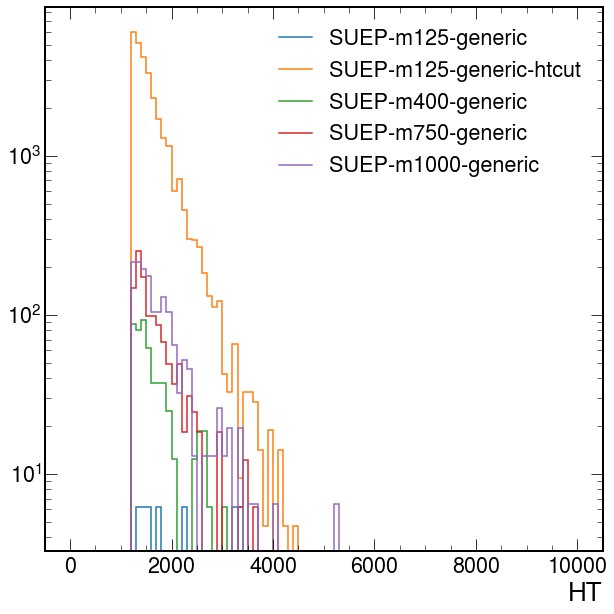

In [36]:
plot_labels = ['ISR_contamination_Cluster']
#samples = ['QCD_HT']
samples = ['SUEP-m125-generic', 'SUEP-m125-generic-htcut', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
density = False

for plot_label in plot_labels:
    for sample in samples: 
        h = plots[sample][plot_label]
        if density: h = h/h.sum().value
        hep.histplot(h, yerr=False, label=sample) 

    # tweak these by hand, as needed
    # plt.ylim(1e4,1e6)
    # plt.xlim(0,150)
    plt.legend()
    plt.yscale("log")
    
    # save and show
    plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')
    plt.show()

## 2D Plots
Plot some of the 2D histograms for any number of samples in the same plot.<br>
Parameters:<br>
`plot_label`: _str_, which plot to show.<br>
`samples`: _list of str_, which samples to include in the plot.<br>
`draw_lines`: _bool_, whether to draw lines in following arguments.<br>
`lines_<dimension>`: _list of floats_, draws lines at given values.

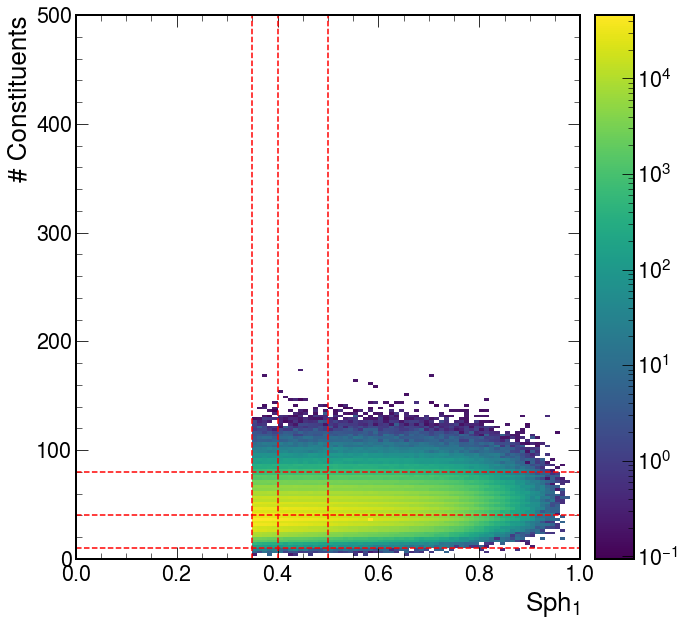

In [14]:
plot_label = '2D_SUEP_S1_SUEP_nconst_CL'
samples = ['QCD_HT']
#samples += ['SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
draw_lines = True
lines_x = [0.35,0.4, 0.5]
lines_y = [10,40,80]

for sample in samples:
    
    if plots[sample][plot_label].sum().value == 0:
        print("Histogram empty for sample", sample)
        continue

    hep.hist2dplot(plots[sample][plot_label], 
               norm=matplotlib.colors.LogNorm(),
               label=sample) 
    
    # draw lines to visualize selections, ABCD regions, etc.
    if draw_lines:
        for y in lines_y: plt.plot([0,10000], [y,y], color='red', linestyle='dashed')
        for x in lines_x: plt.plot([x,x], [0,1000], color='red', linestyle='dashed')
    
    plt.savefig(output_label + plot_label+ "_"+sample+file_ext)
    plt.show()

## Ratio Plots
Make ratio plots of different datasets.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`plot_labels`: _list of str_, which plots to make.

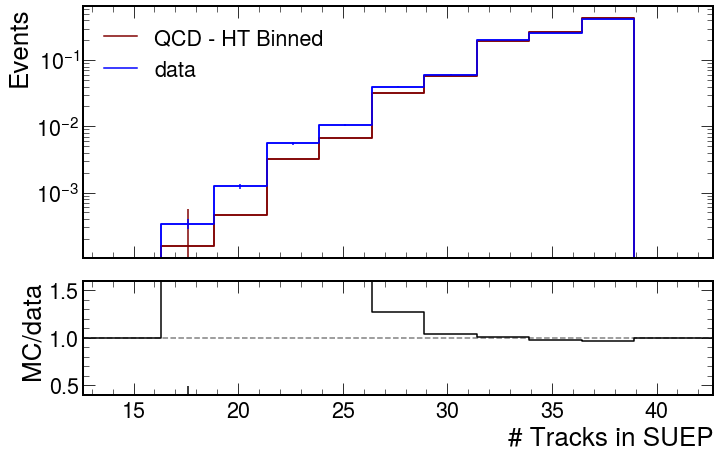

In [20]:
selection = 'Cluster'
plot_labels = ['A_SUEP_nconst']
density = True

for plot_label in plot_labels:
    
    plot_label += '_'+selection

    h1 = plots['QCD_HT'][plot_label][::1j]
    h2 = plots['data'][plot_label][::1j]
    
    # our custom ratio calculates errors differently, more appropriate for plotting densities
    if density:
        h1 /= h1.sum().value
        h2 /= h2.sum().value
        fig, axs, _ = plot_ratio(h1, h2, label1='QCD - HT Binned', label2='data')
        axs[0].legend()
    else:            
        fig = plt.figure(figsize=(10, 8))
        _ = h1.plot_ratio(h2,
                         rp_num_label='QCD - HT Binned',
                         rp_denom_label='data')
 
    fig.axes[0].set_yscale("log")
    #fig.axes[0].set_xlim(0, 2000)
    #fig.axes[0].set_ylim(1e-5, 1e7)
    fig.axes[1].set_ylim(0.4,1.6)
    fig.axes[1].set_ylabel('MC/data')
    plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')
    plt.show()

### SUEP vs. ISR Comparison

In [13]:
plot_label = 'SUEP_nconst'

# QCD hist for ABCD region
h1 = plots['QCD_HT'][plot_label+"_Cluster"][::2j]
h2 = plots['QCD_HT'][plot_label.replace("SUEP", "ISR") +"_ClusterInverted"][::2j]

h1 /= h1.sum().value
h2 /= h2.sum().value

fig = plt.figure(figsize=(10, 8))
hep.histplot(h1, yerr=False, label='SUEP') 
hep.histplot(h2, yerr=False, label='ISR') 

fig.axes[0].set_yscale("log")
# fig.axes[0].set_xlabel("pT")
#fig.axes[0].set_xlim(0, 2000)
#fig.axes[0].set_ylim(1e-5, 1e7)
# fig.axes[1].set_ylim(0.4,1.6)
plt.legend(bbox_to_anchor=(1, 0.5))
plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')
plt.show()

KeyError: 'ISR_nconst_ClusterInverted'

### Ratio Plots: Shared x-axis
Make ratio plots of all regions combined into one histogram.<br>

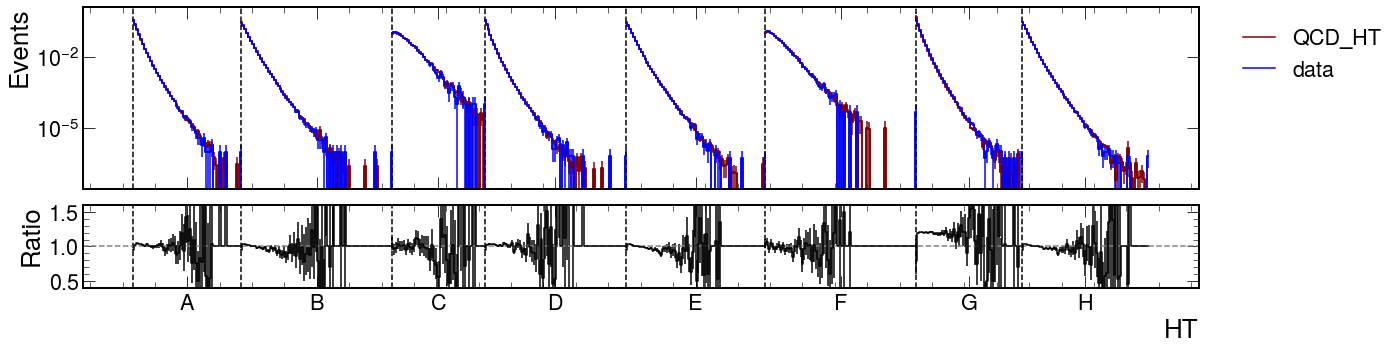

In [17]:
x = 'ABCDEFGH'
y = 'ADGBEHCF'
plot_labels = ['ht_Cluster']
for plot_label in plot_labels:
    _ = plot_ratio_regions(plots, 'A_'+plot_label, 'QCD_HT', 'data', x, density=True)

### Weights

In [ ]:
plot_label = 'SUEP_nconst_CL'
regions = x = 'ABCDEFGHI'
density = False

weights = nested_dict(2, float)
for r in regions:
    
    plot = r + "_" + plot_label
    
    # control regions
    if r != 'I':
        h1 = plots['QCD_HT'][plot]
        h2 = plots['data'][plot]

        fig, _, res = plot_ratio(h1, h2)
        plt.close()

        x = h1.to_numpy()[1]
        ratios = res[0]+1

        weights[r]['bins'] = x
        weights[r]['ratios'] = ratios
    
    # signal region
    else:
        
        h1 = plots['QCD_HT']['F_'+plot_label]
        F = h1.sum().value
        G = plots['QCD_HT']['G_'+plot_label].sum().value
        C = plots['QCD_HT']['C_'+plot_label].sum().value
        A = plots['QCD_HT']['A_'+plot_label].sum().value
        H = plots['QCD_HT']['H_'+plot_label].sum().value
        E = plots['QCD_HT']['E_'+plot_label].sum().value
        D = plots['QCD_HT']['D_'+plot_label].sum().value
        B = plots['QCD_HT']['B_'+plot_label].sum().value
        
        h1 = h1 * F**3 * (G * C / A) * \
                ((H / E)**4) \
                * (G * F / D)**-2 \
                * (H * C / B)**-2
        
        h2 = plots['data']['F_'+plot_label]
        F = h2.sum().value
        G = plots['data']['G_'+plot_label].sum().value
        C = plots['data']['C_'+plot_label].sum().value
        A = plots['data']['A_'+plot_label].sum().value
        H = plots['data']['H_'+plot_label].sum().value
        E = plots['data']['E_'+plot_label].sum().value
        D = plots['data']['D_'+plot_label].sum().value
        B = plots['data']['B_'+plot_label].sum().value
        
        h2 = h2 * F**3 * (G * C / A) * \
                ((H / E)**4) \
                * (G * F / D)**-2 \
                * (H * C / B)**-2
        
        fig, _, res = plot_ratio(h1, h2, plot, 'QCD_HT', 'data')
        plt.close()
        
        x = h1.to_numpy()[1]
        ratios = res[0]+1

        weights[r]['bins'] = x
        weights[r]['ratios'] = ratios
        
weights = dict(weights)
np.save('nconst_weights', weights)

## Automatic Plotting
Make all plots in the pkl and save them automatically.<br>

### All 1D and 2D Plots

In [12]:
outdir = 'allplots/'
samples = ['QCD_HT', 'QCD_HT_scout']
density = True

plot_labels = [k for k in list(plots['QCD_HT'].keys())]
if not os.path.isdir(output_label+outdir): os.system("mkdir " + str(output_label+outdir))

for plot_label in plot_labels:
    
    # 2D plots
    if '2D' in plot_label:
        
        print(plot_label, end=", ")
        
        for sample in samples:

            if plots[sample][plot_label].sum().value == 0:
                print("Histogram empty for sample", sample, end=", ")
                continue

            h = plots[sample][plot_label]
            hep.hist2dplot(h, 
                       norm=matplotlib.colors.LogNorm(),
                       label=sample) 
            plt.savefig(output_label + outdir + plot_label+ "_"+sample+file_ext, bbox_inches='tight')
            plt.close()
        
    # 1D variables
    elif '2D' not in plot_label:
    
        print(plot_label, end=", ")
        
        if plots[sample][plot_label].sum().value == 0:
                print("Histogram empty for sample", sample, end=", ")
                continue
        
        # plot everything
        for sample in samples:
            h = plots[sample][plot_label]
            if density: h = h/h.sum().value
            hep.histplot(h, yerr=True, label=sample) 
        plt.legend()
        plt.yscale("log")
        plt.savefig(output_label + 'allplots/' + plot_label+ "_all"+file_ext, bbox_inches='tight')
        plt.close()

    print()
print("All done")

ABCDvars_ISRRemoval, Histogram empty for sample QCD_HT_scout, ht_ISRRemoval, 
ht_tracker_ISRRemoval, 
ntracks_ISRRemoval, 
ngood_fastjets_ISRRemoval, 
PV_npvs_ISRRemoval, 
Pileup_nTrueInt_ISRRemoval, Histogram empty for sample QCD_HT_scout, ngood_ak4jets_ISRRemoval, 
ngood_tracker_ak4jets_ISRRemoval, 
FNR_ISRRemoval, Histogram empty for sample QCD_HT_scout, ISR_contamination_ISRRemoval, Histogram empty for sample QCD_HT_scout, A_ht_ISRRemoval, 
A_ht_tracker_ISRRemoval, 
A_ntracks_ISRRemoval, 
A_ngood_fastjets_ISRRemoval, 
A_PV_npvs_ISRRemoval, 
A_Pileup_nTrueInt_ISRRemoval, Histogram empty for sample QCD_HT_scout, A_ngood_ak4jets_ISRRemoval, 
A_ngood_tracker_ak4jets_ISRRemoval, 
A_FNR_ISRRemoval, Histogram empty for sample QCD_HT_scout, A_ISR_contamination_ISRRemoval, Histogram empty for sample QCD_HT_scout, B_ht_ISRRemoval, 
B_ht_tracker_ISRRemoval, 
B_ntracks_ISRRemoval, 
B_ngood_fastjets_ISRRemoval, 
B_PV_npvs_ISRRemoval, 
B_Pileup_nTrueInt_ISRRemoval, Histogram empty for sample QCD

### All Ratios: 1D Plots
For each 1D histogram, make a ratio plot between two samples.

In [ ]:
plot_labels = list(plots['QCD_HT'].keys())
density = True
combos = [['QCD_HT','data'],['QCD_Pt','data']]

for l1, l2 in combos:
    
    outdir = l1+"_"+l2+"/"
    print(outdir)

    if not os.path.isdir(output_label+outdir): 
        os.system("mkdir " + str(output_label+outdir))

    for plot_label in plot_labels:

        if '2D' in plot_label: continue

        print(plot_label, end=", ")
        h1 = plots[l1][plot_label]
        h2 = plots[l2][plot_label]
        
        if h1.sum().value == 0 or h2.sum().value == 0: continue
        
        if density: 
            h1 /= h1.sum().value
            h2 /= h2.sum().value
            fig, axs, _ = plot_ratio(h1, h2, label1=l1, label2=l2)
            axs[0].legend()
        else:
            fig = plt.figure(figsize=(10, 8))
            _ = h1.plot_ratio(h2,
                             rp_num_label=l1,
                             rp_denom_label=l2)
            fig.axes[0].set_yscale("log")
            fig.axes[1].set_ylim(0.4,1.6)
            
        plt.savefig(output_label + outdir + plot_label +file_ext, bbox_inches='tight')
        plt.close()

        print()
    print("All done")

QCD_HT_data/
ABCDvars_ISRRemoval, ht_ISRRemoval, 
ht_tracker_ISRRemoval, 
ntracks_ISRRemoval, 
ngood_fastjets_ISRRemoval, 
PV_npvs_ISRRemoval, 
Pileup_nTrueInt_ISRRemoval, ngood_ak4jets_ISRRemoval, 
ngood_tracker_ak4jets_ISRRemoval, 
FNR_ISRRemoval, ISR_contamination_ISRRemoval, A_ht_ISRRemoval, 
A_ht_tracker_ISRRemoval, 
A_ntracks_ISRRemoval, 
A_ngood_fastjets_ISRRemoval, 
A_PV_npvs_ISRRemoval, 
A_Pileup_nTrueInt_ISRRemoval, A_ngood_ak4jets_ISRRemoval, 
A_ngood_tracker_ak4jets_ISRRemoval, 
A_FNR_ISRRemoval, A_ISR_contamination_ISRRemoval, B_ht_ISRRemoval, 
B_ht_tracker_ISRRemoval, 
B_ntracks_ISRRemoval, 
B_ngood_fastjets_ISRRemoval, 
B_PV_npvs_ISRRemoval, 
B_Pileup_nTrueInt_ISRRemoval, B_ngood_ak4jets_ISRRemoval, 
B_ngood_tracker_ak4jets_ISRRemoval, 
B_FNR_ISRRemoval, B_ISR_contamination_ISRRemoval, C_ht_ISRRemoval, 
C_ht_tracker_ISRRemoval, 
C_ntracks_ISRRemoval, 
C_ngood_fastjets_ISRRemoval, 
C_PV_npvs_ISRRemoval, 
C_Pileup_nTrueInt_ISRRemoval, C_ngood_ak4jets_ISRRemoval, 
C_ngood_t

### All Ratios: Combined Regions

In [7]:
density = True

plot_labels = list(plots['QCD_HT'].keys())
combos = [['QCD_HT','QCD_HT_scout']]

for l1, l2 in combos:
    
    outdir = l1+"_"+l2+"_combinedRegions/"
    print(outdir)

    if not os.path.isdir(output_label+outdir): 
        os.system("mkdir " + str(output_label+outdir))

    for plot_label in plot_labels:

        if "A_" not in plot_label: continue
        print(plot_label, end=", ")
        
        h1 = plots[l1][plot_label.replace("A_", "")]
        h2 = plots[l2][plot_label.replace("A_", "")]
        if h1.sum().value == 0 or h2.sum().value == 0:
            print("Empty", end=", ")
            continue
            
        # x or y define order of regions
        x = 'ABCDEFGH'
        y = 'ADGBEHCF'
        _ = plot_ratio_regions(plots, plot_label, l1, l2, x, density=density)
        plt.savefig(output_label + outdir + plot_label +file_ext, bbox_inches='tight')
        plt.close()

QCD_HT_QCD_HT_scout_combinedRegions/
A_ht_ISRRemoval, A_ht_tracker_ISRRemoval, A_ntracks_ISRRemoval, A_ngood_fastjets_ISRRemoval, A_PV_npvs_ISRRemoval, A_Pileup_nTrueInt_ISRRemoval, Empty, A_ngood_ak4jets_ISRRemoval, A_ngood_tracker_ak4jets_ISRRemoval, A_FNR_ISRRemoval, Empty, A_ISR_contamination_ISRRemoval, Empty, A_SUEP_nconst_ISRRemoval, A_SUEP_pt_ISRRemoval, A_SUEP_pt_avg_ISRRemoval, A_SUEP_pt_avg_b_ISRRemoval, A_SUEP_pt_mean_scaled_ISRRemoval, A_SUEP_eta_ISRRemoval, A_SUEP_phi_ISRRemoval, A_SUEP_mass_ISRRemoval, A_SUEP_S1_ISRRemoval, A_SUEP_girth, Empty, A_SUEP_rho0_ISRRemoval, A_SUEP_rho1_ISRRemoval, A_ht_Cluster, A_ht_tracker_Cluster, A_ntracks_Cluster, A_ngood_fastjets_Cluster, A_PV_npvs_Cluster, A_Pileup_nTrueInt_Cluster, Empty, A_ngood_ak4jets_Cluster, A_ngood_tracker_ak4jets_Cluster, A_FNR_Cluster, Empty, A_ISR_contamination_Cluster, Empty, A_SUEP_nconst_Cluster, A_SUEP_pt_Cluster, A_SUEP_pt_avg_Cluster, A_SUEP_pt_avg_b_Cluster, A_SUEP_pt_mean_scaled_Cluster, A_SUEP_eta_Clus

## Binned QCD Plots
Make plots with the QCD separated by bins. This won't work if QCD has been marged. <br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`plot_labels`: _list_, which plots you want to make.<br>
`identifier`: _str_, how to identify the QCD samples, e.g. QCD_HT or QCD_Pt.

500to700_2016
300to500_2016
100to200_2016
700to1000_2016
1000to1500_2016
200to300_2016
2000toInf_2016
1500to2000_2016


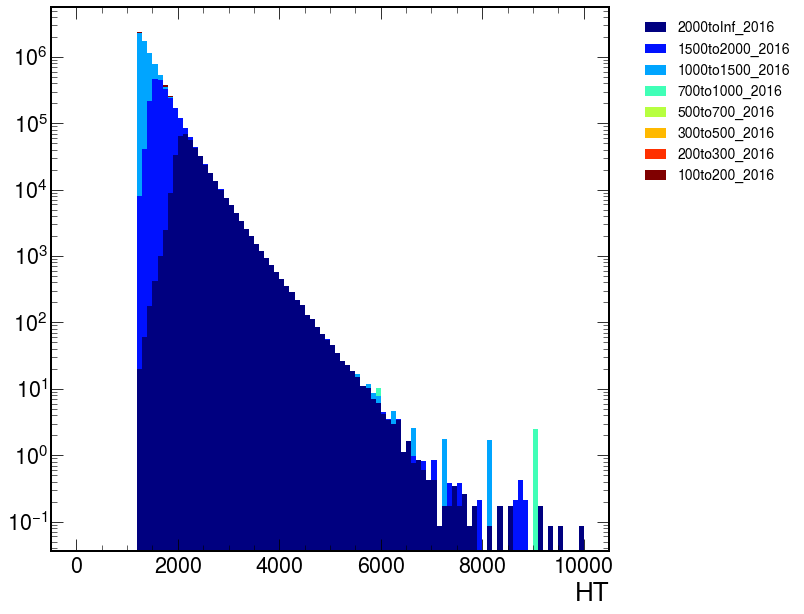

In [26]:
plot_labels = ['ht_Cluster']
#samples = ['1500to2000', '500to700', '100to200', '200to300', '300to500', '2000toInf', '1000to1500']
samples = ['500to700_2016', '300to500_2016', '100to200_2016', '700to1000_2016', '1000to1500_2016', '200to300_2016', '2000toInf_2016', '1500to2000_2016']

for plot_label in plot_labels:
        
    # get hists
    hlist, labels = [], []
    for sample in samples:
        print(sample)
        hlist.append(plots[sample][plot_label])
        labels.append(sample)
                        
    # not sure why, but they NEED to be color coded appropriately
    vals = []
    for key in labels:
        key = key.split("_")[0]
        keyslice = key.split("to")[0]
        val = int(keyslice)
        vals.append(val)
    hlist_sorted, labels_sorted = [], []
    for arg in np.argsort(vals)[::-1]:
        hlist_sorted.append(hlist[arg])
        labels_sorted.append(labels[arg])
        
    cmap = plt.cm.jet(np.linspace(0, 1, len(labels_sorted)))
    
    hep.histplot(hlist_sorted, yerr=True, stack=True, histtype ='fill',
                 label=labels_sorted, color=cmap)
    
    plt.legend(fontsize=14, framealpha=1, facecolor='white', shadow=True, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.yscale("log")
    plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')
    plt.show()

## ABCD
Make the ABCD regions by hand from one of the 2D plots.<br>
Notation: `hist[v1:v2::sum]` sums along an axis from v1 to v2 (leave either blank to extend the summation bounds arbitrarily).

### ABCD Independent Variables Check
1D slices of 2D plots, usually used to check the independence of the ABCD method's two variables on the QCD sample. This won't work if QCD has been binned by pt. <br>
N.B.: Imaginary numbers are used to access the bin value; using real numbers would access the bin number (see hist documentation for more info).<br>
Parameters:<br>
`plot_label`:_str_, which plot to analyze.<br>
`sample`: _str_, which sample to analyze.<br>
`variables`: _str_, variables being sliced, used to pick the slices in the loop.<br>
`slices`: _list of lists of floats_, bins of values to be sliced. e.g. for equal slices use np.linspace(start, end, number of bins), if not can specify as [[0,10],[20,40],[40,50],...].

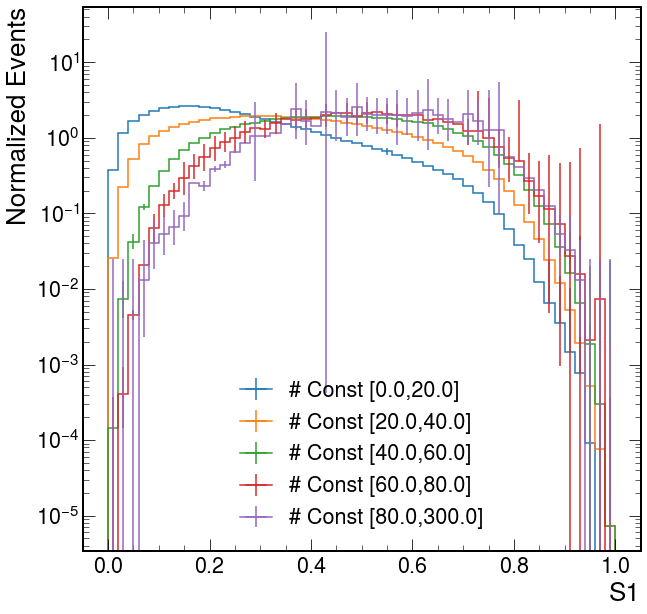

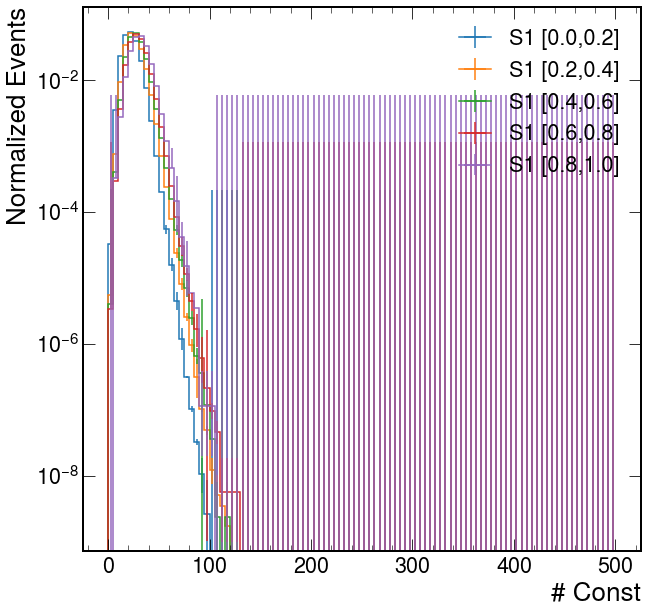

In [13]:
# parameters
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
sample = 'QCD_HT_scout'
variables = ['S1', '# Const']

for i in range(2):
    
    slice_label = variables[(i+1)%2]
    
    if slice_label == '# Tracks': slices = [[0j,40j],[40j,80j],[80j,120j],[120j,140j],[140j,160j],[160j,500j]]
    elif slice_label == '# Const': slices = [[0j,20j],[20j,40j],[40j,60j],[60j,80j],[80j,300j]]
    elif slice_label == 'pT Avg': slices = [[0.0j,20j],[20j,40j],[40j,60j],[60j,80j],[80j,1000j]]
    elif slice_label == 'pT Avg b': slices = [[0.0j,2j],[2j,4j],[4j,6j],[6j,10j],[10j,1000j]]
    elif slice_label == 'pT Mean Scaled': slices = [[0.0j, 0.1j],[0.1j,0.2j],[0.2j,0.4j],[0.4j,0.6j],[0.6j, 1.0j]]
    elif slice_label == 'Classifier Output': slices = [[0.0j,0.05j],[0.05j,0.1j],[0.1j,0.2j],[0.2j,0.4j],[0.4j,0.6j],[0.6j,0.8j],[0.8j,0.9j], [0.9j,1.0j]]
    elif slice_label == 'S1': slices = [[0.0j,0.2j],[0.2j,0.4j],[0.4j,0.6j],[0.6j,0.8j],[0.8j,1.0j]]

    for j in range(len(slices)):
        val_lo = slices[j][0]
        val_up = slices[j][1]
        
        if i==0: 
            h = plots[sample][plot_label][::2j,val_lo:val_up:sum]
        elif i==1:
            h = plots[sample][plot_label][val_lo:val_up:sum, ::2j]

        hep.histplot(h,
                     yerr=True, density=True, 
                     label=slice_label+" [{0},{1}]".format(val_lo.imag, val_up.imag))    
    
    plt.legend()
    #plt.ylim(1e-6,1e0)
    plt.yscale('log')
    plt.ylabel("Normalized Events")
    plt.xlabel(variables[i])
    plt.savefig(output_label + plot_label + "_" + slice_label.replace("#","n").replace(" ","_") + "_SLICES" + file_ext,  bbox_inches='tight')
    plt.show()

### D Region Closure
Check closure in D region for one sample.

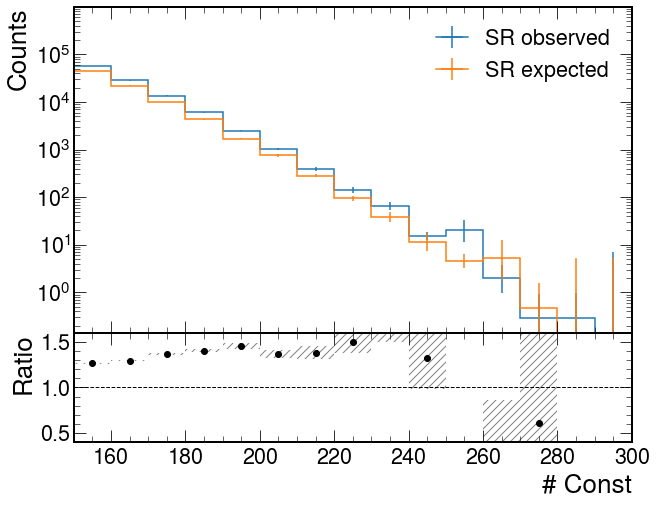

In [28]:
plot_label = '2D_SUEP_S1_vs_ntracks_ISRRemoval'
abcd = plots['QCD_HT'][plot_label]
A = abcd[0.35j:0.5j:sum,0.0j:100.0j:2j]
B = abcd[0.35j:0.5j:sum,100.0j:300.0j:2j]
C = abcd[0.5j:1.0j:sum,0.0j:100.0j:2j]
D = abcd[0.5j:1.0j:sum,100.0j:300.0j:2j]
D_exp = B * C.sum().value / A.sum().value

fig = plt.figure(figsize=(10, 8))
main, sub = D.plot_ratio(D_exp,
                rp_num_label='SR observed',
                rp_denom_label='SR expected',
                rp_uncert_draw_type="bar")
fig.axes[0].set_yscale("log")
fig.axes[0].set_xlim(150,300)
fig.axes[1].set_xlabel("# Const")
fig.axes[1].set_ylim(0.4,1.6)
plt.savefig(output_label+"ABCD_"+plot_label+file_ext)

### 6 Regions

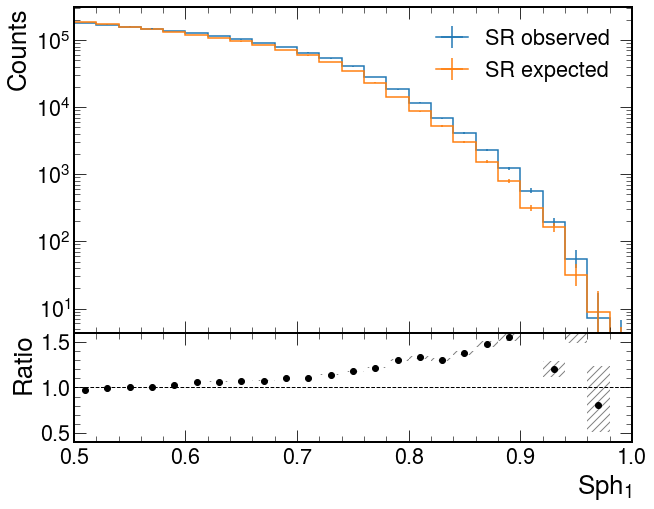

In [30]:
plot_label = '2D_SUEP_S1_vs_ntracks_ISRRemoval'
abcd = plots['QCD_HT'][plot_label]

A = abcd[0.35j:0.4j:2j,0.0j:100j:sum]
B = abcd[0.4j:0.5j:2j,0.0j:100j:sum]
C = abcd[0.5j:1.0j:2j,0.0j:100j:sum]
D = abcd[0.35j:0.4j:2j,100j::sum]
E = abcd[0.4j:0.5j:2j,100j::sum]
F = abcd[0.5j:1.0j:2j,100j::sum]
F_exp = C * E.sum().value**2 * A.sum().value / (B.sum().value**2 * D.sum().value)

fig = plt.figure(figsize=(10, 8))
main, sub = F.plot_ratio(F_exp,
                rp_num_label='SR observed',
                rp_denom_label='SR expected',
                rp_uncert_draw_type="bar")
fig.axes[0].set_yscale("log")
fig.axes[0].set_xlim(0.5,1)
fig.axes[1].set_ylim(0.4,1.6)
plt.savefig(output_label+"ABCD_6regions_"+plot_label+file_ext)

### 9 Regions

0.9578855320697234


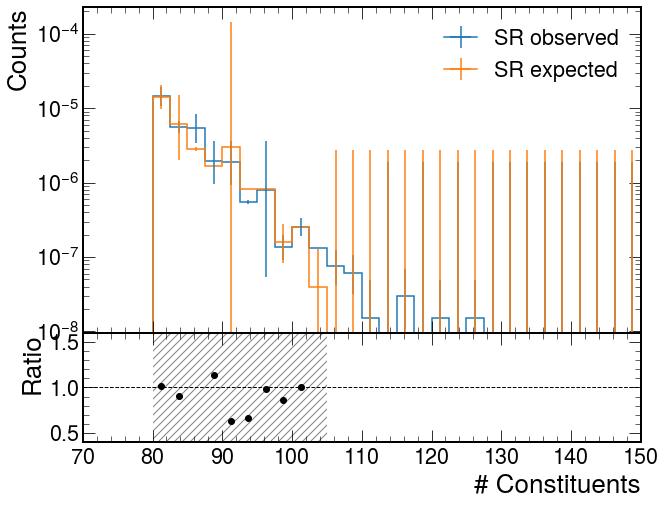

In [15]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
abcd = plots['QCD_HT_scout'][plot_label]

# 2D_SUEP_S1_SUEP_nconst_CL
A = abcd[0.35j:0.4j:sum,10.0j:40j]
B = abcd[0.35j:0.4j:sum,40j:80j]
C = abcd[0.35j:0.4j:sum,80j:300j]
D = abcd[0.4j:0.5j:sum,10.0j:40j]
E = abcd[0.4j:0.5j:sum,40j:80j]
F = abcd[0.4j:0.5j:sum,80j:300j]
G = abcd[0.5j:1.0j:sum,10.0j:40j]
H = abcd[0.5j:1.0j:sum,40j:80j]
SR = abcd[0.5j:1.0j:sum,80j:300j]

# SR_exp = H * H.sum().value **3 * (G.sum().value * C.sum().value / A.sum().value) * \
#         ((F.sum().value / E.sum().value)**4) \
#         * (G.sum().value * F.sum().value / D.sum().value)**-2 \
#         * (H.sum().value * C.sum().value / B.sum().value)**-2

SR_exp = F * F.sum().value**3 * (G.sum().value * C.sum().value / A.sum().value) * \
        ((H.sum().value / E.sum().value)**4) \
        * (G.sum().value * F.sum().value / D.sum().value)**-2 \
        * (H.sum().value * C.sum().value / B.sum().value)**-2

print(SR_exp.sum().value/SR.sum().value)

fig = plt.figure(figsize=(10, 8))
main, sub = SR.plot_ratio(SR_exp,
                rp_num_label='SR observed',
                rp_denom_label='SR expected',
                rp_uncert_draw_type="bar")
fig.axes[0].set_yscale("log")
fig.axes[0].set_xlim(70,150)
fig.axes[1].set_ylim(0.4,1.6)
plt.savefig(output_label+"ABCD_9regions_"+plot_label+file_ext)

#### 9 Regions with error propagation

Scaling factor alpha: 2.31316593875057
Sigma alpha: 0.0402784562810192


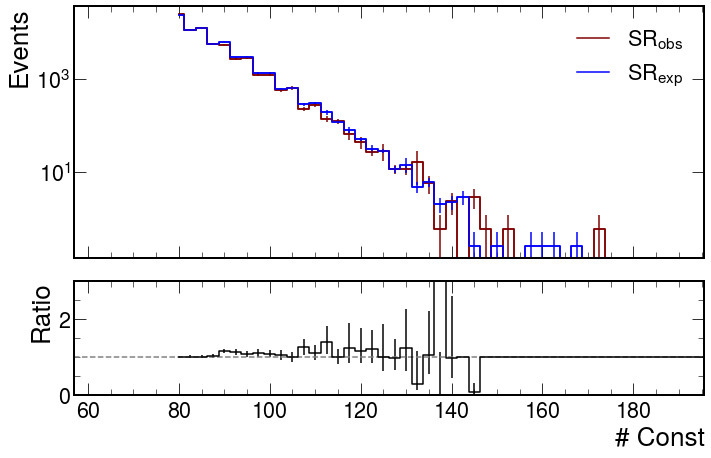

In [25]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
abcd = plots['QCD_HT_2018'][plot_label]

# # 2D_SUEP_S1_SUEP_nconst_CL
A = abcd[0.35j:0.4j:sum,10.0j:40j]
B = abcd[0.35j:0.4j:sum,40j:80j]
C = abcd[0.35j:0.4j:sum,80j:300j]
D = abcd[0.4j:0.5j:sum,10.0j:40j]
E = abcd[0.4j:0.5j:sum,40j:80j]
F = abcd[0.4j:0.5j:sum,80j:300j]
G = abcd[0.5j:1.0j:sum,10.0j:40j]
H = abcd[0.5j:1.0j:sum,40j:80j]
SR = abcd[0.5j:1.0j:sum,80j:300j]

# 2D_ISR_S1_ISR_nconst_CL
# A = abcd[0.35j:0.4j:sum,0.0j:30j]
# B = abcd[0.35j:0.4j:sum,30j:60j]
# C = abcd[0.35j:0.4j:sum,60j:300j]
# D = abcd[0.4j:0.5j:sum,0.0j:30j]
# E = abcd[0.4j:0.5j:sum,30j:60j]
# F = abcd[0.4j:0.5j:sum,60j:300j]
# G = abcd[0.5j:1.0j:sum,0.0j:30j]
# H = abcd[0.5j:1.0j:sum,30j:60j]
# SR = abcd[0.5j:1.0j:sum,60j:300j]

# 2D_SUEP_S1_SUEP_nconst_CL (scouting)
# A = abcd[0.35j:0.4j:sum,10.0j:35j]
# B = abcd[0.35j:0.4j:sum,35j:60j]
# C = abcd[0.35j:0.4j:sum,60j:300j]
# D = abcd[0.4j:0.5j:sum,10.0j:35j]
# E = abcd[0.4j:0.5j:sum,35j:60j]
# F = abcd[0.4j:0.5j:sum,60j:300j]
# G = abcd[0.5j:1.0j:sum,10.0j:35j]
# H = abcd[0.5j:1.0j:sum,35j:60j]
# SR = abcd[0.5j:1.0j:sum,60j:300j]

from sympy import symbols, diff, sqrt
import sympy

# define the scaling factor function
a, b, c, d, e, f, g, h = symbols('A B C D E F G H')
exp = h**2 * d**2 * b**2 * g**-1 * c**-1 * a**-1 * e**-4 * f**1

# defines lists of variables (sympy symbols) and accumulators (hist.sum())
variables = [a, b, c, d, e, f, g, h]
accs = [A.sum(), B.sum(), C.sum(),
        D.sum(), E.sum(), F.sum(),
       G.sum(), H.sum()]

# calculate scaling factor by substituting values of the histograms' sums for the sympy symbols
alpha = exp
for var, acc in zip(variables, accs):
    alpha = alpha.subs(var, acc.value)
    
# calculate the error on the scaling factor
sigma = 0
for var, acc in zip(variables, accs):
    der = diff(exp, var)
    var = abs(acc.variance)
    sigma += der**2 * var
for var, acc in zip(variables, accs):
    sigma = sigma.subs(var, acc.value)
sigma = sqrt(sigma)

print("Scaling factor alpha:", alpha)
print("Sigma alpha:", sigma)

# define SR_exp and propagate the error on the scaling factor to the bin variances
SR_exp = F.copy()
new_var = SR_exp.values()**2 * float(sigma)**2 + float(alpha)**2 * abs(SR_exp.variances())
SR_exp.view().variance = new_var
SR_exp.view().value = SR_exp.view().value * float(alpha)

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
fig, axs, _ = plot_ratio(SR_exp, SR, "# Const", "$SR_{obs}$", "$SR_{exp}$")
_ = axs[1].set_ylim(0,3.0)
_ = axs[0].legend()

### Residuals

In [ ]:
plot_label = '2D_SUEP_S1_ntracks_IRM'
var_label = 'S1'
sample1 = 'QCD_HT'
sample2 = 'data'

abcd = plots[sample1][plot_label]
A = abcd[0.35j:0.5j,0j:100j:sum]
B = abcd[0.35j:0.5j,100j::sum]
C = abcd[0.5j:1.0j,0j:100j:sum]
D_exp = C * B.sum().value / A.sum().value

abcd2 = plots[sample2][plot_label]
A2 = abcd2[0.35j:0.5j,0j:100j:sum]
B2 = abcd2[0.35j:0.5j,100j::sum]
C2 = abcd2[0.5j:1.0j,0j:100j:sum]
D_exp2 = C2 * B2.sum().value / A2.sum().value

hists, hists2  = [A,B,C,D_exp], [A2, B2, C2, D_exp2]
labels = ['A','B','C','D_exp']
avgs, errs = [], []
for h1, h2, label in zip(hists, hists2, labels):
    
    h1 /= h1.sum().value
    h2 /= h2.sum().value
    fig, _, res = plot_ratio(h1, h2, var_label, sample1, sample2)
    plt.close()
    
    residuals = res[0]
    residual_stddevs = []
    for e1, e2 in zip(res[1][0], res[1][1]):
        if np.isinf(e1) and np.isinf(e2):
            print("well well well")
        elif np.isinf(e2):
            residual_stddevs.append(e1)
        elif np.isinf(e1):
            residual_stddevs.append(e1)
        else:
            residual_stddevs.append(max(e1,e2))
    residual_vars = np.array(residual_stddevs)**2
    residuals = abs(residuals[~np.isnan(residual_vars)])
    residual_vars = residual_vars[~np.isnan(residual_vars)]
    
    # Using Hist's fancy tools
    # wmean.value equivalent to np.sum(residuals/residual_vars) / np.sum(1/residual_vars)
    wmean = hist.accumulators.WeightedMean().fill(residuals, weight=1/residual_vars)
    
    # why is this difference from np.sqrt(wmean.variance)
    #test2 = 1/np.sqrt(np.sum(1/residual_vars))
    #print(test2, np.sqrt(wmean.variance))
    
    avgs.append(wmean.value)
    errs.append(np.sqrt(wmean.variance))
    
from IPython.display import display, Latex
for i in range(len(labels)):
    display(Latex(labels[i] + ' ' + str(round(avgs[i],3)) + '$\pm$' + str(round(errs[i],3))))

## Calculate Yields
Integrate histograms to calculate yields.<br>
Parameters:<br>
`lumi`: _float_, scales MC data.<br>
`plot_label`: _str_, which plot you want to integrate.

In [ ]:
plot_label = 'SUEP_nconst_CL'
samples = ['QCD_HT']
samples += ['SUEP-m125-generic', 'SUEP-m400-generic',
           'SUEP-m750-generic', 'SUEP-m1000-generic']
samples += ['SUEP-m125-darkPho', 'SUEP-m400-darkPho',
           'SUEP-m750-darkPho', 'SUEP-m1000-darkPho']
samples += ['SUEP-m125-darkPhoHad', 'SUEP-m400-darkPhoHad',
           'SUEP-m750-darkPhoHad', 'SUEP-m1000-darkPhoHad']

for sample in samples:
    h = plots[sample][plot_label]
    passing = h[70j:].sum().value
    total = h.sum().value
    print(sample, round(passing/total, 3))

## Table

Make comparison table by running next cells. The output is meant to be in Latex format.<br>
The `stats` nested dictionary stores the number of events and variances in each region for real data and MC data when the plots are made, and is used to make the comparison table. Dimensions: (real or MC) x (plot label) x (value or error on the value)

In [ ]:
# dimensions: (sample) x (plot label) x (value or error on the value)
stats = nested_dict(4,float)
selection = 'ch'

for plot_label in ['A','B','C','D_exp']:
    
    plot_label+="_"+selection
    
    # QCD hist for ABCD region
    hdata = plots['data'][plot_label]
    hQCD_MC = plots['QCD_MC'][plot_label]
        
    # fill these up for the table
    stats['data'][plot_label]["value"] = hdata.sum().value
    stats['data'][plot_label]["err"] = hdata.sum().variance
    stats['QCD_MC'][plot_label]["value"] = hQCD_MC.sum().value
    stats['QCD_MC'][plot_label]["err"] = hQCD_MC.sum().variance

In [ ]:
table = []
for i in range(len(list(stats.keys()))):
    label = list(stats.keys())[i]
    line = []
    line.append(label)
    
    for r in ['A_'+selection,'B_'+selection,'C_'+selection,'D_exp_'+selection,'D_obs_'+selection]:
        if 'QCD_MC' in label:
            line.append("{:0.0f} ".format(stats[label][r]['value']) + r'$\pm$' + " {:0.0f}".format(stats[label][r]['err']))
        else:
            line.append("{:0.2f} ".format(stats[label][r]['value']) + r'$\pm$' + " {:0.2f}".format(stats[label][r]['err']))
        
    if 'QCD_MC' in label:
        line.append(round((stats[label]['D_exp_'+selection]['value']-stats[label]['D_obs_'+selection]['value'])/stats[label]['D_exp_'+selection]['value'],2))
        line.append(0)
    else:
        line.append(0)
        line.append(stats[label]['D_obs_'+selection]['value']/math.sqrt(stats[label]['D_obs_'+selection]['value']+stats[label]['D_exp_'+selection]['value']+stats[label]['D_obs_'+selection]['err']+stats['QCD_MC']['D_exp_'+selection]['err']))
    table.append(line)                                                         

In [ ]:
t = tabulate(table,tablefmt ='latex',
               headers=['Process', 'A', 'B', 'C', 'D_{exp}', 'D_{obs}', 'D_{exp}-D_{obs}/D_{exp}', 'S/$\sqrt(S+B+\sigma_{S}+\sigma_{B}$)'])
with open('table.txt', 'w') as f:
    f.write(t)
t

In [ ]:
def convert2LatexString(s):
    r = r'(\^\{\})'; s = re.sub(r, "^", s)
    s = re.sub(r'\\([\$\_\{\}\^])', r'\1', s)
    s = re.sub(r'(\\textbackslash{})', r'\\', s)
    return s

t = convert2LatexString(t)
with open('table.txt', 'w') as f:
    f.write(t)
t